In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy.interpolate import splprep, splev
from skimage.draw import polygon

### 1. functions to create shapes

In [1]:
def create_circle(center=(100, 100), radius=40, size=(200, 200)):
    y, x = np.ogrid[:size[0], :size[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    return mask.astype(np.uint8)

def create_square(top_left=(60, 60), length=80, size=(200, 200)):
    mask = np.zeros(size, dtype=np.uint8)
    mask[top_left[1]:top_left[1]+length, top_left[0]:top_left[0]+length] = 1
    return mask

def create_diamond(center=(100, 100), size=80, img_size=(200, 200)):
    y, x = np.ogrid[:img_size[0], :img_size[1]]
    mask = np.abs(x - center[0]) + np.abs(y - center[1]) <= size // 2
    return mask.astype(np.uint8)

def create_triangle(vertices=[(100, 60), (60, 140), (140, 140)], img_size=(200, 200)):
    rr, cc = polygon([v[1] for v in vertices], [v[0] for v in vertices], img_size)
    mask = np.zeros(img_size, dtype=np.uint8)
    mask[rr, cc] = 1
    return mask

def create_polygon(vertices, img_size=(200, 200)):
    from skimage.draw import polygon
    rr, cc = polygon([v[1] for v in vertices], [v[0] for v in vertices], img_size)
    mask = np.zeros(img_size, dtype=np.uint8)
    mask[rr, cc] = 1
    return mask

def create_star(n_points=5, r_outer=40, r_inner=20, center=(100, 100), img_size=(200, 200)):
    angles = np.linspace(0, 2*np.pi, n_points*2, endpoint=False)
    radii = np.array([r_outer if i % 2 == 0 else r_inner for i in range(len(angles))])
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)
    return create_polygon(list(zip(x, y)), img_size)

### contour extraction

In [4]:
def resample_contour(x, y, num_points=256):
    tck, u = splprep([x, y], s=0, per=True)
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    return np.array(x_new), np.array(y_new)
  
def extract_contour(binary_mask, num_points=256):
    contours = measure.find_contours(binary_mask, 0.5)
    largest = max(contours, key=len)
    return resample_contour(largest[:, 1], largest[:, 0], num_points)

### fourier descriptors and reconstruction

In [33]:
def normalize_fd(Z):
    Z[0] = 0
    Z /= np.abs(Z[1])
    return Z
  
def compute_fd(x, y, normalize=True):
    z = x + 1j * y
    Z = np.fft.fft(z)
    return normalize_fd(Z) if normalize else Z
  
def low_pass(Z, num_points=256):
    Z_ = np.zeros_like(Z, dtype=complex)
    Z_[0] = Z[0]
    Z_[1:num_points//2] = Z[1:num_points//2]
    Z_[-num_points//2+1:] = Z[-num_points//2+1:]
    return Z_
  
def reconstruct_shape(Z):
    z = np.fft.ifft(Z)
    return z.real, z.imag

### interpolation methods

In [34]:
# Interpolation in real-imaginary space
def interpolate_fd_real_imag(fd_seq, t_vals, target_t):
    fd_array = np.array(fd_seq)
    interpolated = []
    for k in range(fd_array.shape[1]):
        real_interp = np.interp(target_t, t_vals, fd_array[:, k].real)
        imag_interp = np.interp(target_t, t_vals, fd_array[:, k].imag)
        interpolated.append(real_interp + 1j * imag_interp)
    return np.array(interpolated)
  
# Interpolation in magnitude-phase space
def interpolate_fd_magnitude_angle(fd_seq, t_vals, target_t):
    fd_array = np.array(fd_seq)  # shape: (T, N)
    interpolated = []

    for k in range(fd_array.shape[1]):
        mag = np.abs(fd_array[:, k])
        angle = np.angle(fd_array[:, k])

        def interp_angle(theta1, theta2, t):
            diff = ((theta2 - theta1 + np.pi) % (2 * np.pi)) - np.pi
            return theta1 + t * diff

        mag_interp = np.interp(target_t, t_vals, mag)
        angle_interp = interp_angle(angle[0], angle[1], (target_t - t_vals[0]) / (t_vals[1] - t_vals[0]))

        interpolated.append(mag_interp * np.exp(1j * angle_interp))

    return np.array(interpolated)

# Hybrid interpolation: real-imag for low freq, mag-angle for high freq
def interpolate_fd_hybrid(fd_seq, t_vals, target_t, split_k=10):
    fd_array = np.array(fd_seq)  # shape: (T, N)
    N = fd_array.shape[1]
    interpolated = []

    for k in range(N):
        if k < split_k:
            # Real-imag interpolation
            real_interp = np.interp(target_t, t_vals, fd_array[:, k].real)
            imag_interp = np.interp(target_t, t_vals, fd_array[:, k].imag)
            interpolated.append(real_interp + 1j * imag_interp)
        else:
            # Magnitude-angle interpolation
            mag = np.abs(fd_array[:, k])
            angle = np.angle(fd_array[:, k])
            def interp_angle(theta1, theta2, t):
                diff = ((theta2 - theta1 + np.pi) % (2 * np.pi)) - np.pi
                return theta1 + t * diff
            mag_interp = np.interp(target_t, t_vals, mag)
            angle_interp = interp_angle(angle[0], angle[1], (target_t - t_vals[0]) / (t_vals[1] - t_vals[0]))
            interpolated.append(mag_interp * np.exp(1j * angle_interp))

    return np.array(interpolated)

# Linear interpolation directly between contours
def interpolate_contours_linear(contour1, contour2, t):
    x1, y1 = contour1
    x2, y2 = contour2
    x_interp = (1 - t) * x1 + t * x2
    y_interp = (1 - t) * y1 + t * y2
    return x_interp, y_interp

### testing!

In [35]:
# given two binary masks, extract contours, interpolate between them, and visualize the results
def visualize_methods(shape1, shape2, num_params=256, num_steps=10):
  t_vals = np.array(np.linspace(0, 1, num_steps))
  
  x1, y1 = extract_contour(shape1)
  x2, y2 = extract_contour(shape2)
  P1 = compute_fd(x1, y1, normalize=True)
  P2 = compute_fd(x2, y2, normalize=True)
  resampled_contour1 = resample_contour(x1, y1, num_points=num_params)
  resampled_contour2 = resample_contour(x2, y2, num_points=num_params)
  sampled_P1 = low_pass(P1, num_params)
  sampled_P2 = low_pass(P2, num_params)
  
  interp_real_imag = [reconstruct_shape(interpolate_fd_real_imag([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_hybrid = [reconstruct_shape(interpolate_fd_hybrid([sampled_P1, sampled_P2], [0, 1], t, split_k=num_params//3)) for t in t_vals]
  interp_mag_angle = [reconstruct_shape(interpolate_fd_magnitude_angle([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_linear = [interpolate_contours_linear(resampled_contour1, resampled_contour2, t) for t in t_vals]
  
  fig, axs = plt.subplots(4, num_steps, figsize=(15, 10))
  
  for i, idx in enumerate(t_vals):
    x1, y1 = interp_real_imag[i]
    x2, y2 = interp_hybrid[i]
    x3, y3 = interp_mag_angle[i]
    x4, y4 = interp_linear[i]
    
    axs[0, i].plot(x1 - np.mean(x1), y1 - np.mean(y1))
    axs[0, i].set_title(f"Real-Imag t={t_vals[i]:.2f}")
    axs[0, i].axis('equal')
    axs[0, i].axis('off')
    
    axs[1, i].plot(x2 - np.mean(x2), y2 - np.mean(y2))
    axs[1, i].set_title(f"Hybrid t={t_vals[i]:.2f}")
    axs[1, i].axis('equal')
    axs[1, i].axis('off')
    
    axs[2, i].plot(x3 - np.mean(x3), y3 - np.mean(y3))
    axs[2, i].set_title(f"Mag-Angle t={t_vals[i]:.2f}")
    axs[2, i].axis('equal')
    axs[2, i].axis('off')
    
    axs[3, i].plot(x4 - np.mean(x4), y4 - np.mean(y4))
    axs[3, i].set_title(f"Linear t={t_vals[i]:.2f}")
    axs[3, i].axis('equal')
    axs[3, i].axis('off')
  
  plt.tight_layout()
  plt.show()

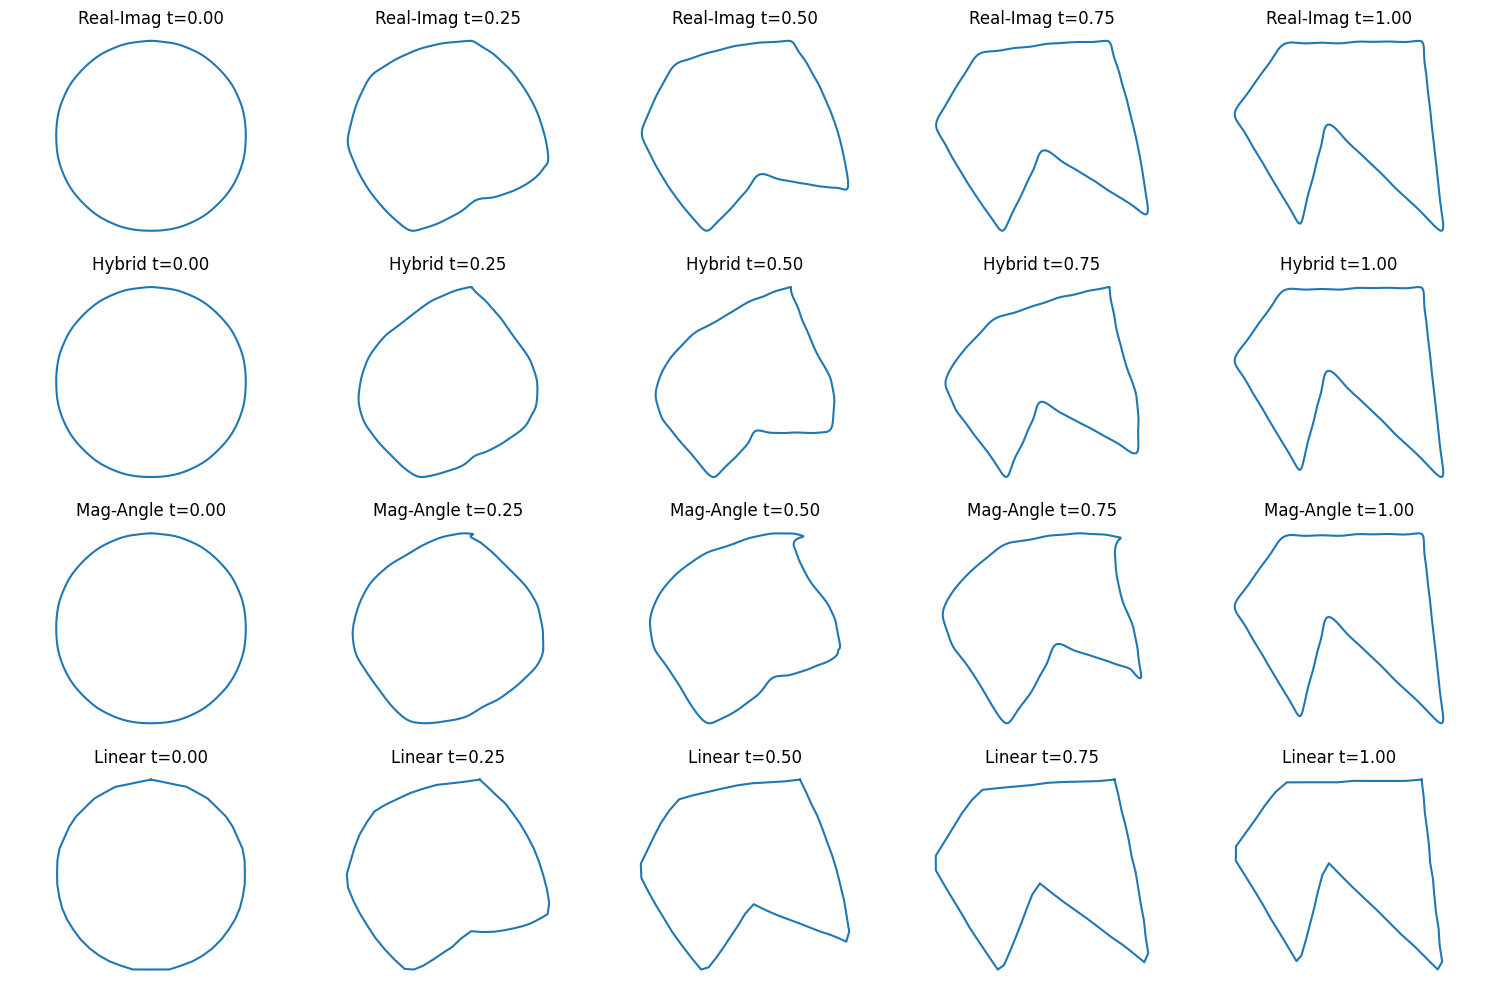

In [37]:
polygon1 = create_circle() #create_polygon(((87, 120), (155, 53), (140, 5), (26, 19)), img_size=(200, 200))
# polygon1 = create_polygon([(50, 50), (150, 50), (100, 150)], img_size=(200, 200))
polygon2 = create_polygon(((75, 102), (55, 24), (5, 108), (42, 160), (146, 162), (162, 18)), img_size=(200, 200))

visualize_methods(polygon1, polygon2, num_params=50, num_steps=5)